In [107]:
from sklearn import decomposition
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import KFold
import random

In [108]:
# Loading data into numpy arrays
inp_paras = np.load('data/inp_paras_995.npy')
aoas_opt = np.load('data/aoas_opt_995.npy')
airfoils_opt = np.load('data/airfoils_opt_995.npy')

# # Evens out array
# inp_paras = inp_paras[:-1]
# aoas_opt = aoas_opt[:-1]
# airfoils_opt = airfoils_opt[:-1]


print(airfoils_opt.reshape(995,-1).shape)
print(inp_paras.shape)
print(aoas_opt.shape)

(995, 384)
(995, 3)
(995,)


In [109]:
# Splitting data into training and testing
x_train = []
x_test = []
y_train = []
y_test = []

k = 10
remainder = inp_paras.shape[0] % k
if(remainder != 0):
    airfoils_opt = airfoils_opt[:-remainder]
    inp_paras = inp_paras[:-remainder]

print(airfoils_opt.shape)
print(inp_paras.shape)

kf = KFold(n_splits=k, shuffle=False)

# only need to split one for indices since they have the same amount of airfoils
for i, (train_index, test_index) in enumerate(kf.split(inp_paras)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")

    # print(len(train_index))
    # print(len(test_index))

    x_train_subsample =[]
    x_test_subsample =[]
    y_train_subsample =[]
    y_test_subsample =[]
    
    for index in train_index:
        x_train_subsample.append(inp_paras[index])
        y_train_subsample.append(airfoils_opt[index])

    for index in test_index:
        x_test_subsample.append(inp_paras[index])
        y_test_subsample.append(airfoils_opt[index])

    x_train.append(np.array(x_train_subsample))
    y_train.append(np.array(y_train_subsample))
    x_test.append(np.array(x_test_subsample))
    y_test.append(np.array(y_test_subsample))

    # x_train.append(x_train_subsample)
    # y_train.append(y_train_subsample)
    # x_test.append(x_test_subsample)
    # y_test.append(y_test_subsample)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1],-1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],-1)

print(x_test.shape)
print(x_train.shape)
print(y_test.shape)
print(y_train.shape)




# n = 0.8
# size_train = int(n*airfoils_opt.shape[0])

# x_train = inp_paras[:size_train]
# y_train = airfoils_opt[:size_train]

# x_test = inp_paras[size_train:]
# y_test = airfoils_opt[size_train:]

# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)


(990, 192, 2)
(990, 3)
(10, 99, 3)
(10, 891, 3)
(10, 99, 384)
(10, 891, 384)


Number of latent dimensions to explain 99% of variance:  5


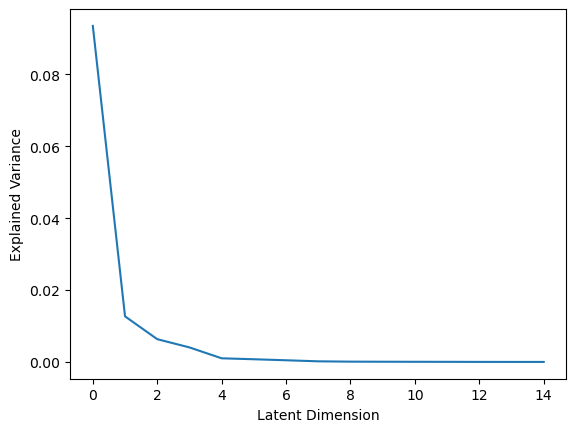

In [110]:

# PCA for dimension reduction of airfoil geometries
# y_train_new = y_train.reshape(y_train.shape[0],-1)
# print(y_train_new.shape)
estimator = decomposition.PCA(n_components=15)
estimator.fit(y_train[0]) 
components_ = estimator.components_

# Scree Plot
# Plotting the explained variance for each latent dimension
plt.plot(estimator.explained_variance_)
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")

cumulative_explained_var_ratio = np.cumsum(estimator.explained_variance_ratio_)
num_dims_to99 = np.argmax(cumulative_explained_var_ratio > .99) # Number of dimesnions needed to explain 99% of variance
print("Number of latent dimensions to explain 99% of variance: ", num_dims_to99)

In [111]:
# Transforming airfoil geometry data into a lower dimension space

y_train_pca = []
y_test_pca = []

pca = PCA(n_components=20)

print(y_train.shape)

for i in range(k):
    pca.fit(y_train[i])
    y_train_pca.append(pca.transform(y_train[i]))
    
    pca.fit(y_test[i])
    y_test_pca.append(pca.transform(y_test[i]))

y_train_pca = np.array(y_train_pca)
y_test_pca = np.array(y_test_pca)

print(y_test_pca.shape)
print(y_train_pca.shape)

(10, 891, 384)
(10, 99, 20)
(10, 891, 20)


In [112]:

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train_pca, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test_pca, dtype=torch.float32)

print(len(x_train[9]))
print(len(y_test[9]))


891
99


In [113]:
# DNN Building
class Airfoil_NN(nn.Module):
    # RelU(Linear) --> ReLU(Linear) --> Linear --> Ouput
    # 2 Hidden Layers with ReLU activations
    def __init__(self, output_param, input_param = 3, neurons_per_layer = [3, 3]):
        super().__init__() 
        self.input_param = input_param
        self.output_param = output_param
        self.neurons_per_layer = neurons_per_layer

        self.hidden1 = nn.Linear(self.input_param, self.neurons_per_layer[0])
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(self.neurons_per_layer[0], self.neurons_per_layer[1])
        self.act2 = nn.ReLU()
        self.output = nn.Linear(self.neurons_per_layer[1], self.output_param)


    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x 

n_epochs =120
batch_size = 40 

y_eval = []

for i in range(k): 
    model = Airfoil_NN(20, 3, [12, 24]) # [output layer neurons, input layer neurons, hiddern layers]

    # train the model
    loss_fn   = nn.HuberLoss(reduction='mean',delta=0.01) # Less sensitive to outliers than MSE
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    # Batch Fed Training Loop

    for epoch in range(n_epochs):
        for j in range(0, len(x_train), batch_size):
            Xbatch = x_train[i][j:j+batch_size]
            y_pred = model(Xbatch)
            ybatch = y_train[i][j:j+batch_size]
            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Performance Monitoring 
        if(epoch % 20 == 0):
            validate_loss = loss_fn(model(x_test[i]),y_test[i]).item()
            print(f"Fold {i}: Epoch {epoch}: Train Loss = {loss.item():.4f}, Test Loss = {validate_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_eval.append(model(x_test[i]).numpy())

Fold 0: Epoch 0: Train Loss = 29828.7656, Test Loss = 60356.0391
Fold 0: Epoch 20: Train Loss = 0.0006, Test Loss = 0.0005
Fold 0: Epoch 40: Train Loss = 0.0003, Test Loss = 0.0003
Fold 0: Epoch 60: Train Loss = 0.0002, Test Loss = 0.0002
Fold 0: Epoch 80: Train Loss = 0.0002, Test Loss = 0.0002
Fold 0: Epoch 100: Train Loss = 0.0002, Test Loss = 0.0002
Fold 1: Epoch 0: Train Loss = 19576.5117, Test Loss = 3385.4512
Fold 1: Epoch 20: Train Loss = 0.0007, Test Loss = 0.0007
Fold 1: Epoch 40: Train Loss = 0.0003, Test Loss = 0.0003
Fold 1: Epoch 60: Train Loss = 0.0002, Test Loss = 0.0002
Fold 1: Epoch 80: Train Loss = 0.0002, Test Loss = 0.0002
Fold 1: Epoch 100: Train Loss = 0.0002, Test Loss = 0.0002
Fold 2: Epoch 0: Train Loss = 23659.9883, Test Loss = 37752.9492
Fold 2: Epoch 20: Train Loss = 0.0008, Test Loss = 0.0007
Fold 2: Epoch 40: Train Loss = 0.0003, Test Loss = 0.0003
Fold 2: Epoch 60: Train Loss = 0.0002, Test Loss = 0.0002
Fold 2: Epoch 80: Train Loss = 0.0002, Test Loss =

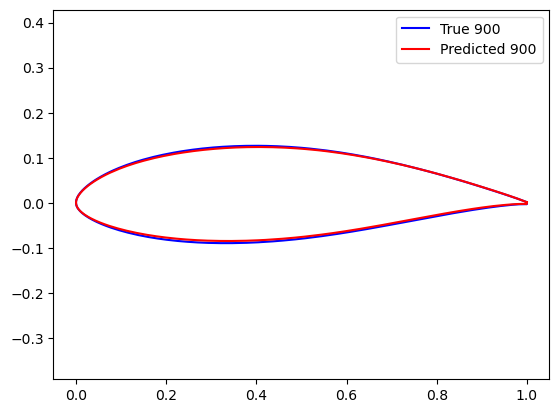

In [114]:
reconstructed_airfoils = pca.inverse_transform(y_eval[9])
reconstructed_airfoils=reconstructed_airfoils.reshape(-1,192,2)

# Pick a real test sample (airfoil_id in [796, 994])
airfoil_id = 900
test_index = airfoil_id - x_train.shape[1]  

plt.plot(airfoils_opt[airfoil_id, :, 0], airfoils_opt[airfoil_id,
         :, 1], label=f"True {airfoil_id}", color='blue')
plt.plot(reconstructed_airfoils[test_index, :, 0], reconstructed_airfoils[test_index,
         :, 1], label=f"Predicted {airfoil_id}", color='red')

plt.axis('equal')
plt.legend()
plt.show()